# Setup

In [ ]:
!pip install tensorflow
!pip install tensorflow-io
!pip install matplotlib

In [ ]:
# Performing this on Google Colab, therefore mounting drive to access data for training and testing
# Command to mount the drive (get or post data to files in the drive, can be done manually; run this only once everytime it reconnects)
from google.colab import drive
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio

# Data Loading

In [ ]:
# Sample files form data
capuchin_file = "/content/drive/MyDrive/Deep Audio Classifier/data/Parsed_Capuchinbird_Clips/XC114131-0.wav"
not_capuchin_file = "/content/drive/MyDrive/Deep Audio Classifier/data/Parsed_Not_Capuchinbird_Clips/afternoon-birds-song-in-forest-0.wav"

In [ ]:
# Function loads a WAV audio file, decodes it, adjusts the sample rate if necessary, and returns the resampled waveform along with its sample rate.
# Loading audio files such as wav files can be done by libraries like librosa and soudfile as well, tf has inbuilt audio I/O so we use it.
def load_wav_file(filename):
  file_contents = tf.io.read_file(filename)
  wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
  wav = tf.squeeze(wav, axis=-1)
  sample_rate = tf.cast(sample_rate, dtype=tf.int64)
  wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
  return wav

<function matplotlib.pyplot.show(close=None, block=None)>

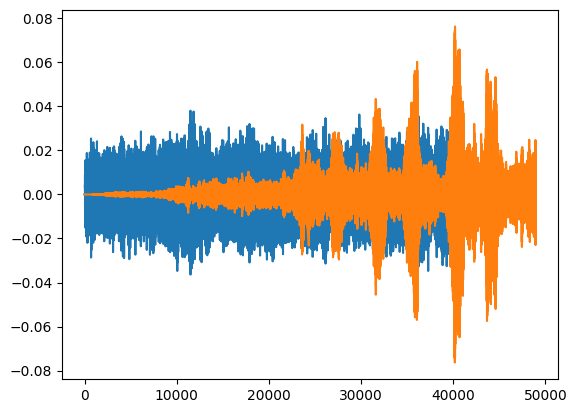

In [ ]:
# Capuchin file and forest file plotting
wave = load_wav_file(capuchin_file)
wave_not = load_wav_file(not_capuchin_file)
plt.plot(wave)
plt.plot(wave_not)
plt.show

# TensorFlow Dataset

In [ ]:
import os

Parsed_Capuchinbird_Clips = "/content/drive/MyDrive/Deep Audio Classifier/data/Parsed_Capuchinbird_Clips"
Parsed_Not_Capuchinbird_Clips = "/content/drive/MyDrive/Deep Audio Classifier/data/Parsed_Not_Capuchinbird_Clips"

def get_all_files(directory):
    # Get a list of all files in the specified directory
    all_files = [os.path.join(directory, file) for file in os.listdir(directory) if file.endswith('.wav')]
    return all_files

# Get all files in the directories
all_pos_files = get_all_files(Parsed_Capuchinbird_Clips)
all_neg_files = get_all_files(Parsed_Not_Capuchinbird_Clips)

pos = tf.data.Dataset.list_files(all_pos_files)
neg = tf.data.Dataset.list_files(all_neg_files)

In [ ]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

In [ ]:
# Length of Capuchin Calls
from os import listdir

lengths = []
for file in listdir(Parsed_Capuchinbird_Clips):
  tensor_wave = load_wav_file(Parsed_Capuchinbird_Clips+"/"+file)
  lengths.append(len(tensor_wave))

In [ ]:
len(lengths)

217

In [ ]:
tf.math.reduce_mean(lengths) # 54,156
tf.math.reduce_min(lengths) # 32,000
tf.math.reduce_max(lengths) # 80,000

<tf.Tensor: shape=(), dtype=int32, numpy=80000>

# Convert to Spectrogram

In [ ]:
def preprocess(file_path, label):
    wav = load_wav_file(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

In [ ]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [ ]:
spectrogram, label = preprocess(filepath, label)

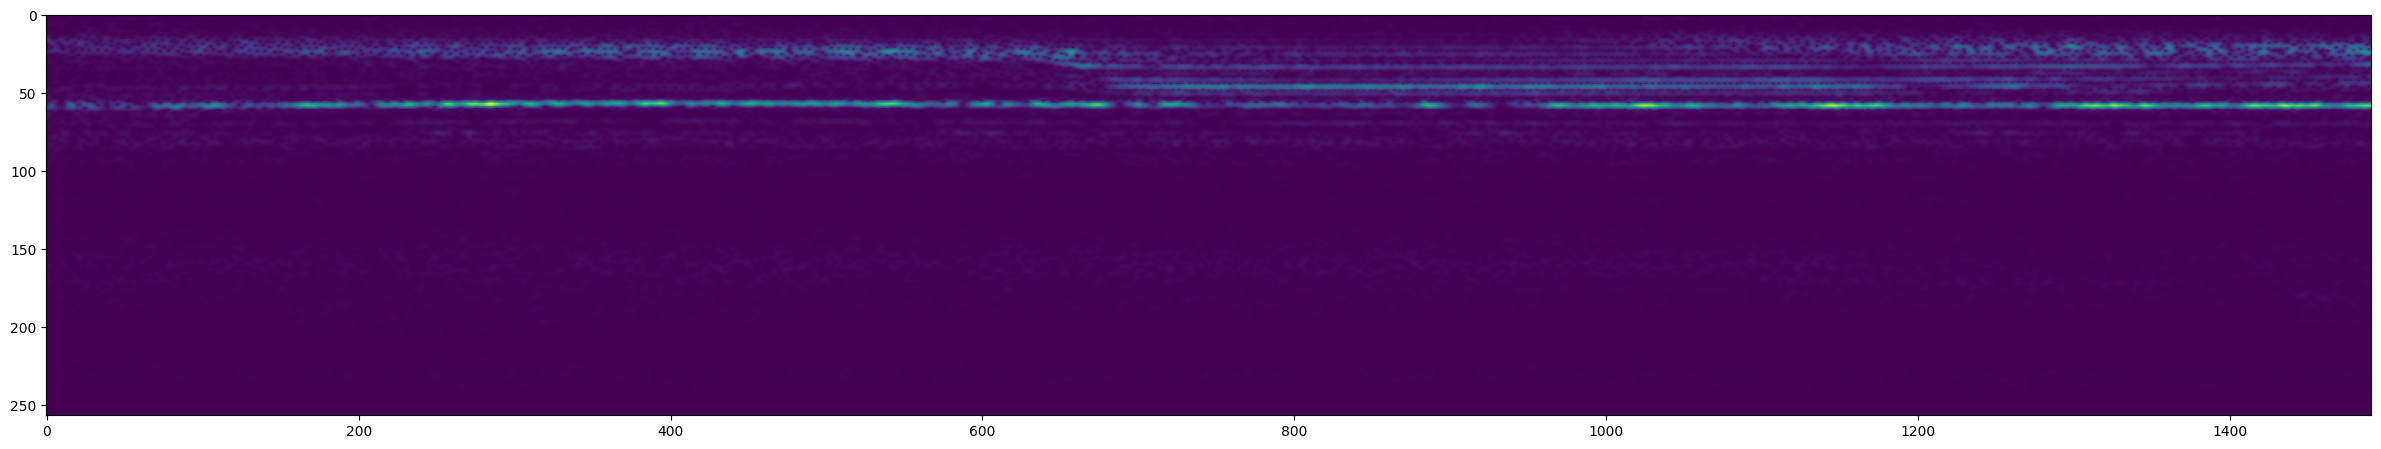

In [ ]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

# Testing and Training Dataset partitioning

In [ ]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

In [ ]:
train = data.take(36)
test = data.skip(36).take(15)

In [ ]:
samples, labels = train.as_numpy_iterator().next()
samples.shape

(16, 1491, 257, 1)

# Deep Learning Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

In [ ]:
# Convolutional Neural Network (CNN) model using the Keras API, specifically the Sequential model.
# ReLU stands for Rectified Linear Unit. It's one of the most commonly used activation functions in neural networks, especially in deep learning models.
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(1491,257,1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1489, 255, 16)     160       
                                                                 
 conv2d_1 (Conv2D)           (None, 1487, 253, 16)     2320      
                                                                 
 flatten (Flatten)           (None, 6019376)           0         
                                                                 
 dense (Dense)               (None, 128)               770480256 
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 770482865 (2.87 GB)
Trainable params: 770482865 (2.87 GB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
hist = model.fit(train, epochs=4, validation_data=test)

Epoch 1/4


In [ ]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

# Prediction

In [ ]:
X_test, y_test = test.as_numpy_iterator().next()
yhat = model.predict(X_test)

In [ ]:
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]